# Neal's Funnel Target Practice

In [1]:
] activate "../"

  Activating project at `~/PhD/MicroCanonicalHMC.jl`


In [2]:
# The statistical inference frame-work we will use
using Turing
using Interpolations
using ForwardDiff
using LinearAlgebra
using Random
#using StatsPlots
using PyPlot
using Distributed

using Revise
using MicroCanonicalHMC

In [3]:
d = 21
@model function funnel()
    θ ~ Normal(0, 3)
    z ~ MvNormal(zeros(d-1), exp(θ)*I)
    x ~ MvNormal(z, I)
end

@model function true_funnel()
    θ ~ Normal(0, 3)
    z ~ MvNormal(zeros(d-1), I)
    zz = z .* exp(θ/2)
    x ~ MvNormal(zz, I)
    
end

true_funnel (generic function with 2 methods)

In [4]:
Random.seed!(1)
(;x) = rand(funnel() | (θ=0,))
funnel_model = funnel() | (;x)

Random.seed!(1)
(;x) = rand(true_funnel() | (θ=0,))
true_model = true_funnel() | (;x)

DynamicPPL.Model{typeof(true_funnel), (), (), (), Tuple{}, Tuple{}, DynamicPPL.ConditionContext{NamedTuple{(:x,), Tuple{Vector{Float64}}}, DynamicPPL.DefaultContext}}(true_funnel, NamedTuple(), NamedTuple(), ConditionContext((x = [0.7273459156073062, -0.7137895625029701, -1.3112158987551843, 3.195064335503728, 0.6578668590997088, 1.8201670957594605, 2.5774094189910475, 1.2959606640141557, -2.615684720848553, -1.7192495259048919, 0.38510954102334116, 0.7049475219687015, 1.4527158089056038, 1.5438517444010695, 0.8504145036053463, 0.9997932200168839, -0.14767140951984356, 0.6046583528834097, -0.38477500804604936, -1.506202996455002],), DynamicPPL.DefaultContext()))

## MCHMC

In [21]:
target = NealFunnelTarget(funnel_model; d=d, compute_MAP=false)

true_target = NealFunnelTarget(true_model; d=d, compute_MAP=false)

spl = MCHMC(0.0, 0.5; init_eps=0.3, varE_wanted=0.5, sigma=ones(d))

true_spl = MCHMC(0.0, 0.5; init_eps=0.3, varE_wanted=0.5, sigma=ones(d))

MicroCanonicalHMC.Sampler(Settings(MersenneTwister(0), 0.5, 0, 1000, 100, "LF", 0.3, nothing, nothing), Hyperparameters(0.0, 0.5, 0.0, 0.1931833275037836, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]), MicroCanonicalHMC.Leapfrog)

In [22]:
samples = Sample(spl, target, 100_000;
                 burn_in=20_000, dialog=true);

[ Info: Using given sigma ✅
[ Info: Tuning eps ⏳
[ Info: Using given L ✅
[ Info: Starting burn in


eps: 0.3 --> VarE/d: 0.0005103796235786936
eps: 0.49436400349728 --> VarE/d: 0.0017969025809268767
eps: 0.7940747025796892 --> VarE/d: 0.0022633480433643417
eps: 

[ Info: Burn in finished


1.2458188302514657 --> VarE/d: 0.0050086224090206116
eps: 1.9075811686920214 --> VarE/d: 34.147353987078155
eps: 5.000000000000004e-5 --> VarE/d: 2.7469470820658175e-9
eps: 7.380477229979013e-5 --> VarE/d: 2.7510196663137216e-9
eps: 0.00010689344563774503 --> VarE/d: 2.7640901360242882e-9
eps: 0.00015204500248988776 --> VarE/d: 2.7998686272929035e-9
eps: 0.00021258386454278187 --> VarE/d: 2.847710641546284e-9
eps: 0.00029240816196266027 --> VarE/d: 2.898656437806012e-9
eps: 0.0003960006961760347 --> VarE/d: 3.119102933079491e-9
eps: 0.0005284197096958967 --> VarE/d: 3.412569925930668e-9
eps: 0.0006952675175477827 --> VarE/d: 3.861883264157925e-9
eps: 0.0009026361839821951 --> VarE/d: 4.887432132416571e-9
eps: 0.001157030657987631 --> VarE/d: 5.9837543717062254e-9
eps: 0.0014652710160242889 --> VarE/d: 8.246735792066848e-9
eps: 0.0018343766024222791 --> VarE/d: 1.1267385818514578e-8
eps: 0.002271435836772026 --> VarE/d: 1.579011007337074e-8
eps: 0.0027834661905721436 --> VarE/d: 1.96885

In [7]:
truth = Sample(true_spl, true_target, 100_000;
               burn_in=20_000, dialog=true);

[ Info: Using given sigma ✅
[ Info: Tuning eps ⏳
[ Info: Using given L ✅
[ Info: Starting burn in


eps: 0.3 --> VarE/d: 0.0004299675482943293
eps: 0.8151339920150719 --> VarE/d: 0.0019895152357919687
eps: 2.106302766594283 --> VarE/d: 7.533495267869946
eps: 

[ Info: Burn in finished


0.005702692645507198 --> VarE/d: 1.771085474786424e-7
eps: 0.01348592138925851 --> VarE/d: 7.863834911517605e-7
eps: 0.030580923223318773 --> VarE/d: 5.55146726435045e-6
eps: 0.06663119425244808 --> VarE/d: 2.2569608347461924e-5
eps: 0.13976666460574544 --> VarE/d: 6.582585314232735e-5
eps: 0.28276496883935215 --> VarE/d: 0.00038666192394315777
eps: 0.5526234860514845 --> VarE/d: 0.0009739895432344374
eps: 1.0449078942636485 --> VarE/d: 0.003416710902851336
eps: 1.9124536705312674 --> VarE/d: 1.3369266858140039
eps: 1.5745937057153185 --> VarE/d: 0.03199093763719759
eps: 2.6784865413858467 --> VarE/d: 51.0187092047082
eps: 5.000000000000004e-5 --> VarE/d: 1.1039533432023388e-8
eps: 8.21550490328866e-5 --> VarE/d: 1.1071723791615014e-8
eps: 0.00013175904676981202 --> VarE/d: 1.1178700996023062e-8
eps: 0.00020650070167617564 --> VarE/d: 1.1304516851577723e-8
eps: 0.00031662519920090237 --> VarE/d: 1.1523372915600754e-8
eps: 0.00047546267972166053 --> VarE/d: 1.2133735994520866e-8
eps: 0.

In [23]:
theta_mchmc = [sample[1] for sample in samples]
x10_mchmc = [sample[10+1] for sample in samples]
E = [sample[end-1] for sample in samples];

In [24]:
true_theta_mchmc = [sample[1] for sample in truth]
true_x10_mchmc = [sample[10+1] * exp(sample[1]/2) for sample in truth];

In [25]:
VarE = std(E)^2/d

0.00025221461943096936

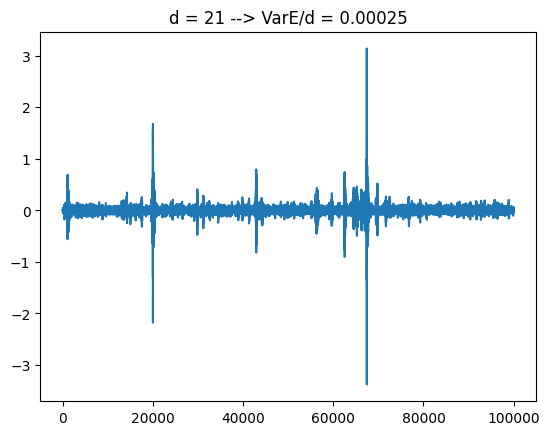

PyObject Text(0.5, 1.0, 'd = 21 --> VarE/d = 0.00025')

In [26]:
plt.plot(E, label="E/d")
plt.title(string("d = ", d, " --> VarE/d = ", round(VarE, digits=5)))

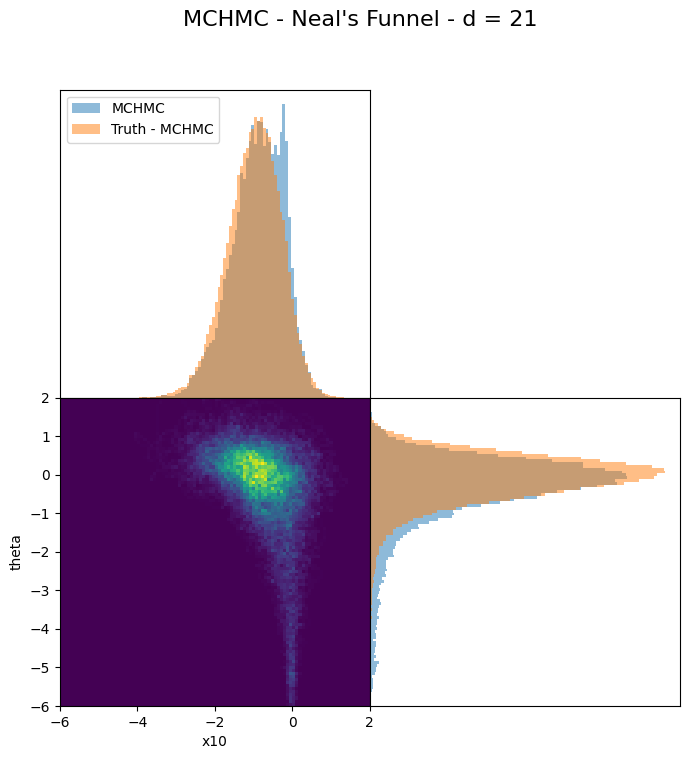

In [27]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle(string("MCHMC - Neal's Funnel - d = ", d), fontsize=16)

fig.delaxes(axis[1,2])
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(x10_mchmc, bins=100, range=[-6,2], alpha = 0.5, label="MCHMC")
axis[1,1].hist(true_x10_mchmc, bins=100, range=[-6,2], alpha = 0.5, label="Truth - MCHMC")
axis[1,1].legend()
axis[1,1].set_yticks([])

axis[2,2].hist(theta_mchmc, bins=100, orientation="horizontal", range=[-6, 2], alpha = 0.5)
axis[2,2].hist(true_theta_mchmc, bins=100, orientation="horizontal", range=[-6, 2], alpha = 0.5)
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[2,1].hist2d(x10_mchmc, theta_mchmc, bins=100, range=[[-6,2],[-6, 2]])
axis[2,1].set_xlabel("x10")
axis[2,1].set_ylabel("theta");

## NUTS

In [28]:
funnel_samples_hmc = sample(true_model, NUTS(10, 0.95), 100_000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.8
Sampling: 100%|█████████████████████████████████████████| Time: 0:01:39


Chains MCMC chain (100000×33×1 Array{Float64, 3}):

Iterations        = 11:1:100010
Number of chains  = 1
Samples per chain = 100000
Wall duration     = 99.85 seconds
Compute duration  = 99.85 seconds
parameters        = θ, z[1], z[2], z[3], z[4], z[5], z[6], z[7], z[8], z[9], z[10], z[11], z[12], z[13], z[14], z[15], z[16], z[17], z[18], z[19], z[20]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse           ess      rhat  ⋯
      Symbol   Float64   Float64    Float64   Float64       Float64   Float64  ⋯

           θ   -0.0763    0.9058     0.0029    0.0064    19506.9271    1.0001  ⋯
        z[1]    0.3399    0.7065     0.0022    0.0018   147101.4172    1.0000  ⋯
        z[2]   -0.3352    0.7088     0.0022    0.0019   146092.4305    1.0000  ⋯
        z[3]   -

In [29]:
theta_hmc = [funnel_samples_hmc.value.data[i, 1, :][1] for i in axes(funnel_samples_hmc.value.data)[1]]
x10_hmc = [funnel_samples_hmc.value.data[i, 10+1, :][1] * exp(funnel_samples_hmc.value.data[i, 1, :][1]/2) for i in axes(funnel_samples_hmc.value.data)[1]];

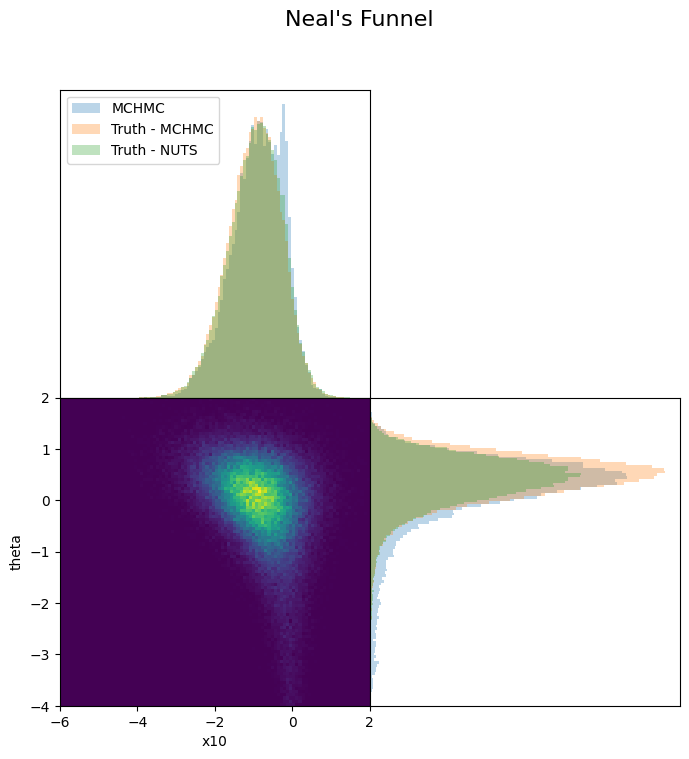

In [30]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("Neal's Funnel", fontsize=16)

fig.delaxes(axis[1,2])
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(x10_mchmc, bins=100, range=[-6,2], alpha = 0.3, label="MCHMC")
axis[1,1].hist(true_x10_mchmc, bins=100, range=[-6,2], alpha = 0.3, label="Truth - MCHMC")
axis[1,1].hist(x10_hmc, bins=100, range=[-6,2], alpha = 0.3, label="Truth - NUTS")
axis[1,1].legend()
axis[1,1].set_yticks([])

axis[2,2].hist(theta_mchmc, bins=100, orientation="horizontal", range=[-6, 2], alpha = 0.3)
axis[2,2].hist(true_theta_mchmc, bins=100, orientation="horizontal", range=[-6, 2], alpha = 0.3)
axis[2,2].hist(theta_hmc, bins=100, orientation="horizontal", range=[-4, 2], alpha = 0.3)
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[2,1].hist2d(x10_hmc, theta_hmc, bins=100, range=[[-6,2],[-4, 2]])
axis[2,1].set_xlabel("x10")
axis[2,1].set_ylabel("theta");